This a regression of the Antoine Equation to vapor pressure data.

In this example we use a nonlinear curve-fitting function: scipy.optimize.curve_fit to give us the parameters in a function that we define which best fit the data. The scipy.optimize.curve_fit function also gives us the covariance matrix which we can use to estimate the standard error of each parameter. Finally, we modify the standard error by a student-t value which accounts for the additional uncertainty in our estimates due to the small number of data points that are being fit.  In addition we will calculate the R^2 value (Coefficient of Variation) and variance and make a residual plot.  This template is based on
https://kitchingroup.cheme.cmu.edu/blog/2013/02/12/Nonlinear-curve-fitting-with-parameter-confidence-intervals/

We will fit the function $$\log{P_{vap}}=A+\frac{B }{C+T}$$ to the Exam 2 data and compute the 95% confidence intervals on the parameters.

In [1]:
# Nonlinear curve fit with confidence interval
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats.distributions import  t
import matplotlib.pyplot as plt

#Ethane-thiol
T = np.array([0.405,5.236,10.111,15.017,19.954,24.933,29.944,35,40.092,45.221,50.39,55.604,60.838,66.115])
T=T+273.15
Pvap = np.array([187.57,233.72,289.13,355.22,433.56,525.86,633.99,760,906.06,1074.6,1268,1489.1,1740.8,2026])
print(T)
print(Pvap)

[273.555 278.386 283.261 288.167 293.104 298.083 303.094 308.15  313.242
 318.371 323.54  328.754 333.988 339.265]
[ 187.57  233.72  289.13  355.22  433.56  525.86  633.99  760.    906.06
 1074.6  1268.   1489.1  1740.8  2026.  ]


In [2]:
testlogPvap=np.log10(187)
testlogPvap

2.271841606536499

In [3]:
logPvap=np.log10(Pvap)
logPvap

array([2.27316338, 2.36869588, 2.46109316, 2.55049741, 2.63704921,
       2.72087014, 2.80208241, 2.88081359, 2.95715696, 3.03124684,
       3.10311925, 3.17292386, 3.24074888, 3.30663944])

## Please note the initial guess for the curve_fit

linearized form of Antoine Equation:  
    $$log{P^{vap}}= A -C\frac{\log{P}}{T}+ \frac{AC+B}{T}$$

## linear fit


In [4]:
# this is the function we want to fit to our data
def func(x, coef1, coef2, coef3):
    #'nonlinear function in ko and E to fit to data'
    logPvap=coef1+coef2*x[0]+coef3*x[1]
    return logPvap

x=np.array([logPvap/T,1/T])
#test function
print(func(x, 1, 1, 1))

[1.01196528 1.01210081 1.01221874 1.01232097 1.01240873 1.01248266
 1.01254424 1.01259391 1.01263291 1.0126621  1.01268195 1.01269315
 1.01269731 1.01269403]


In [5]:
#Now for the linear fit!
pars, pcov = curve_fit(func, x, logPvap)
print('pars=', pars)
print('pcov=',pcov)

pars= [    6.95221879    41.75518761 -1374.90429575]
pcov= [[ 1.22345389e-05 -7.70982449e-04 -1.56702889e-03]
 [-7.70982449e-04  4.88146802e-02  9.81107016e-02]
 [-1.56702889e-03  9.81107016e-02  2.02507075e-01]]


In [6]:
#Test of the above
logPvapCalc=pars[0]+pars[1]*np.log(Pvap)/T+pars[2]/T
logPvapCalc

array([2.72509338, 2.83144284, 2.93372416, 3.03196752, 3.12639063,
       3.21733091, 3.30484062, 3.38924998, 3.47060133, 3.54906506,
       3.62479315, 3.69798026, 3.76850288, 3.83669592])

In [7]:
alpha = 0.05 # 95% confidence interval = 100*(1-alpha)

n = len(Pvap)    # number of data points
p = len(pars) # number of parameters

dof = max(0, n - p) # number of degrees of freedom

# student-t value for the dof and confidence level
tval = t.ppf(1.0-alpha/2., dof)
print(n,p,dof,tval)

14 3 11 2.200985160082949


In [8]:
#confidence limit width is obtained from covariance matrix and tvalue
#print(np.diag(pcov)**0.5*tval)
print(np.diag(pcov))

[1.22345389e-05 4.88146802e-02 2.02507075e-01]


In [9]:
print('    Parameter  +/- 95% confidence  [lower 95%   upper 95%]')
for i, p,var in zip(range(n), pars, np.diag(pcov)):
    sigma = var**0.5
    
    print ('p{:d}: {:7.5f} +/- {:7.5f}       [{:7.5f}  {:7.5f}]'
           .format(i, p,sigma*tval,p - sigma*tval,p + sigma*tval))


    Parameter  +/- 95% confidence  [lower 95%   upper 95%]
p0: 6.95222 +/- 0.00770       [6.94452  6.95992]
p1: 41.75519 +/- 0.48629       [41.26890  42.24147]
p2: -1374.90430 +/- 0.99046       [-1375.89476  -1373.91384]


## The above matches the Excel File
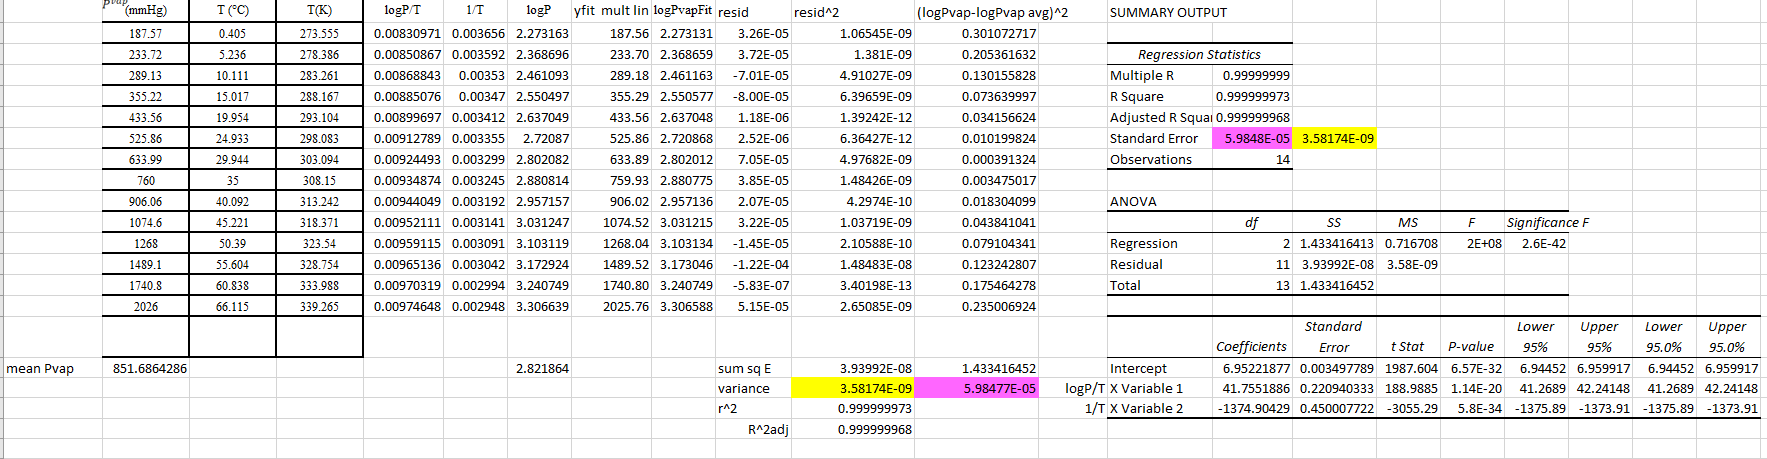

In [10]:
residuals = logPvapCalc-logPvap
ss_res = np.sum(residuals**2)
variance=ss_res/(len(Pvap)-len(pars))
print(residuals)
print('variance={:7.5}'.format(variance))

[0.45193    0.46274697 0.472631   0.48147011 0.48934143 0.49646078
 0.50275821 0.50843638 0.51344437 0.51781823 0.5216739  0.52505639
 0.52775401 0.53005647]
variance=0.31908


In [11]:
ss_res = np.sum(residuals**2)
ss_tot = np.sum((logPvap-np.mean(logPvap))**2)
r_squared = 1 - (ss_res/ss_tot)
print('r^2={:9.9f}'.format(r_squared))

r_squaredAdj=1-ss_res/(len(Pvap)-len(pars))/ss_tot*(len(Pvap)-1)
print('r^2Adj={:9.9f}'.format(r_squaredAdj))

r^2=-1.448586094
r^2Adj=-1.893783566


[2.27313074 2.36865872 2.46116323 2.55057739 2.63704803 2.72086761
 2.80201186 2.88077507 2.95713623 3.03121463 3.10313377 3.17304572
 3.24074946 3.30658795]


Text(0.5, 1.0, 'Antoine Equation')

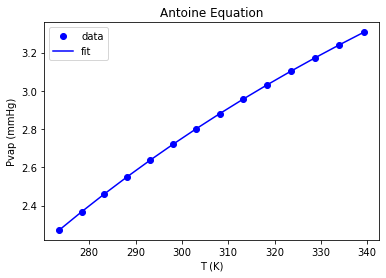

In [12]:
plt.plot(T,logPvap,'bo ')

yfit =  pars[0]+ pars[1]*np.log10(Pvap)/T+ pars[2]/T
print(yfit)
plt.plot(T,yfit,'b-')
plt.legend(['data','fit'],loc='best')
plt.xlabel('T (K)')
plt.ylabel('Pvap (mmHg)')
plt.title('linear Regression Result of the Antoine Equation')

What is the variance based on $P^{vap}$ instead of $logP^{vap}$ for the inearized fit?  This will allow us to compare the nonlinear and linearized fits on a common basis.

In [13]:
#This will be used to compare variances on common basis:  Pvap
residuals = 10**logPvapCalc-10**logPvap
ss_res = np.sum(residuals**2)
variancePvapLin=ss_res/(len(Pvap)-len(pars))
print(residuals)
print('Linearized variance based on Pvap ={:7.5}'.format(variance))

[ 343.42860144  444.61284256  569.33809399  721.16471474  904.23828467
 1123.55869635 1383.63577884 1690.47330868 2049.23833367 2465.90379468
 2946.95704937 3499.51807275 4127.37267627 4839.87536878]
Linearized variance based on Pvap =0.31908


In [14]:
ss_res = np.sum(residuals**2)
ss_tot = np.sum((10**logPvap-10**np.mean(logPvap))**2)
r_squared = 1 - (ss_res/ss_tot)
print('r^2={:9.9f}'.format(r_squared))

r_squaredAdj=1-ss_res/(len(Pvap)-len(pars))/ss_tot*(len(Pvap)-1)
print('r^2Adj={:9.9f}'.format(r_squaredAdj))

r^2=-14.872836542
r^2Adj=-17.758806822


## Nonlinear fit (With no initial values the curve_fit function can not find a solution.  It does not converge after 800 iterations!

In [15]:
# this is the function we want to fit to our data
def funcNL(T, A, B, C):
    #'nonlinear function in ko and E to fit to data'
    Pvap=10**(A+B/(T+C))
    return Pvap

pars, pcov = curve_fit(funcNL, T, Pvap)
print('pars=', pars)
print('pcov=',pcov)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

## This needs an initial guess which we will calculate from linear fit
 $$log{P^{vap}}= A  -C\frac{\log{P}}{T}+\frac{AC+B}{T}=coef1+coef2\frac{\log{P}}{T}+\frac{coef3}{T}$$
 So this gives
 $$A=coef1$$
 $$B=coef3-AC$$
 $$C=-coef2$$

In [16]:
#Test of equation with array input
coef1=6.952218775      #intercept
coef2=41.7551886       #logP/T
coef3=-1374.904        #1/T
x=np.array([logPvap/T,1/T])
logPvaptest=coef1+coef2*x[0,0]+coef3*x[1,0]
print(logPvaptest)
print(x)

2.273131811077646
[[0.00830971 0.00850867 0.00868843 0.00885076 0.00899697 0.00912789
  0.00924493 0.00934874 0.00944049 0.00952111 0.00959115 0.00965136
  0.00970319 0.00974648]
 [0.00365557 0.00359213 0.00353031 0.00347021 0.00341176 0.00335477
  0.00329931 0.00324517 0.00319242 0.00314099 0.00309081 0.00304179
  0.00299412 0.00294755]]


In [17]:
#linearized equation in terms of A, B and C
A=coef1           #intercept
C=-coef3          #1/T
B= coef2-A*C      #logP/T
          
print(A,B,C)
#below is a check to make sure the math in lines 2-4 gives the same result!
#x[0] is logP/T  x[1] is  1/T based on x=np.array([[logPvap/T,1/T])

print(10**(coef1+coef2*x[0,0]+coef3*x[1,0]))
print(10**(A+(A*C+B)*x[0,0]-C*x[1,0]))
print(x)

6.952218775 -9516.878214022601 1374.904
187.5563666934992
187.55636669349957
[[0.00830971 0.00850867 0.00868843 0.00885076 0.00899697 0.00912789
  0.00924493 0.00934874 0.00944049 0.00952111 0.00959115 0.00965136
  0.00970319 0.00974648]
 [0.00365557 0.00359213 0.00353031 0.00347021 0.00341176 0.00335477
  0.00329931 0.00324517 0.00319242 0.00314099 0.00309081 0.00304179
  0.00299412 0.00294755]]


In [18]:
# this is the function we want to fit to our data
def funcNL(T, A, B, C):
    #'nonlinear function in ko and E to fit to data'
    return 10**(A+B/(T+C))
#From a multiple linear fit the parameters are:
initial_guess = [A,B,C]

#pars, pcov = curve_fit(funcNL, T, Pvap, p0=initial_guess)
pars, pcov = curve_fit(funcNL, T, Pvap, p0=initial_guess)
print('pars=', pars)
print('pcov=',pcov)


pars= [    6.95693034 -1087.17721607   -41.43534026]
pcov= [[ 3.44806755e-05 -1.89205794e-02  2.37819788e-03]
 [-1.89205794e-02  1.03935404e+01 -1.30791502e+00]
 [ 2.37819788e-03 -1.30791502e+00  1.64792159e-01]]


C:\Users\hesketh\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.


In [19]:
pfit=funcNL(T, pars[0],pars[1],pars[2])
print(pfit)

[ 187.60196519  233.73809643  289.21694646  355.31712726  433.56586875
  525.84925397  633.84901018  759.88765534  905.96657276 1074.46183945
 1268.00879704 1489.55896974 1740.82131308 2025.80705401]


The $+/-$ confidence interval is defined as an element from the diagonal of the covariance matrix to the 1/2 power times the tvalue.

In [20]:
alpha = 0.05 # 95% confidence interval = 100*(1-alpha)

n = len(Pvap)    # number of data points
p = len(pars) # number of parameters

dof = max(0, n - p) # number of degrees of freedom

# student-t value for the dof and confidence level
tval = t.ppf(1.0-alpha/2., dof) 
print('    Parameter  +/- 95% confidence  [lower 95%   upper 95%]')
for i, p,var in zip(range(n), pars, np.diag(pcov)):
    sigma = var**0.5
    
    print ('p{:d}: {:7.5f} +/- {:7.5f}       [{:7.5f}  {:7.5f}]'
           .format(i, p,sigma*tval,p - sigma*tval,p + sigma*tval))


    Parameter  +/- 95% confidence  [lower 95%   upper 95%]
p0: 6.95693 +/- 0.01292       [6.94401  6.96985]
p1: -1087.17722 +/- 7.09576       [-1094.27298  -1080.08146]
p2: -41.43534 +/- 0.89348       [-42.32882  -40.54186]


In [21]:
PvapCalc=10**(pars[0]+pars[1]/(T+pars[2]))
PvapCalc

array([ 187.60196519,  233.73809643,  289.21694646,  355.31712726,
        433.56586875,  525.84925397,  633.84901018,  759.88765534,
        905.96657276, 1074.46183945, 1268.00879704, 1489.55896974,
       1740.82131308, 2025.80705401])

In [22]:
print(np.diag(pcov))
print(np.diag(pcov)[0]**0.5*t.ppf(1.0-alpha/2., dof) )
print(np.diag(pcov)[1]**0.5*t.ppf(1.0-alpha/2., dof) )
print(np.diag(pcov)[2]**0.5*t.ppf(1.0-alpha/2., dof) )

[3.44806755e-05 1.03935404e+01 1.64792159e-01]
0.012924239481956517
7.095759186771018
0.8934811331772312


In [23]:
residuals = PvapCalc-Pvap
ss_res = np.sum(residuals**2)
variance=ss_res/(len(Pvap)-len(pars))
print('variance={:7.5}'.format(variance))
print('variance for Linearized Fit={:7.5}'.format(variancePvapLin))

variance=0.029747
variance for Linearized Fit=7.2439e+06


In [24]:
ss_res = np.sum(residuals**2)
ss_tot = np.sum((Pvap-np.mean(Pvap))**2)
r_squared = 1 - (ss_res/ss_tot)
print('r^2={:7.5e}'.format(r_squared))

r_squaredAdj=1-ss_res/(len(Pvap)-len(pars))/ss_tot*(len(Pvap)-1)
print('r^2Adj={:7.5e}'.format(r_squaredAdj))

r^2=1.00000e+00
r^2Adj=1.00000e+00


Text(0.5, 1.0, 'Antoine Equation')

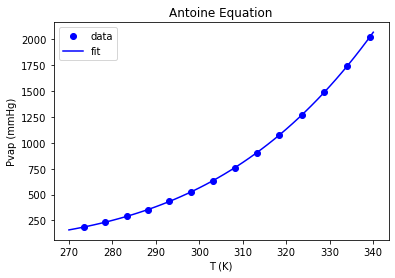

In [25]:
plt.plot(T,Pvap,'bo ')
xfit = np.linspace(270,340)
yfit = funcNL(xfit, pars[0], pars[1], pars[2])
plt.plot(xfit,yfit,'b-')
plt.legend(['data','fit'],loc='best')
plt.xlabel('T (K)')
plt.ylabel('Pvap (mmHg)')
plt.title('Antoine Equation')

Text(0, 0.5, '$P^{vap}_{exp}$  - $P^{vap}_{calc}$')

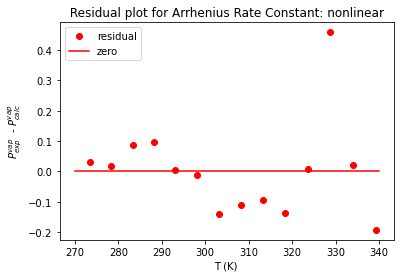

In [26]:
plt.plot(T,residuals,'ro',label='residual')
plt.plot([270,340],[0,0],'r-',label='zero')
plt.legend(loc='best')
plt.title(' Residual plot for Arrhenius Rate Constant: nonlinear ')
plt.xlabel('T (K) ')
plt.ylabel('$P^{vap}_{exp}$  - $P^{vap}_{calc}$')

## Polymath Plus
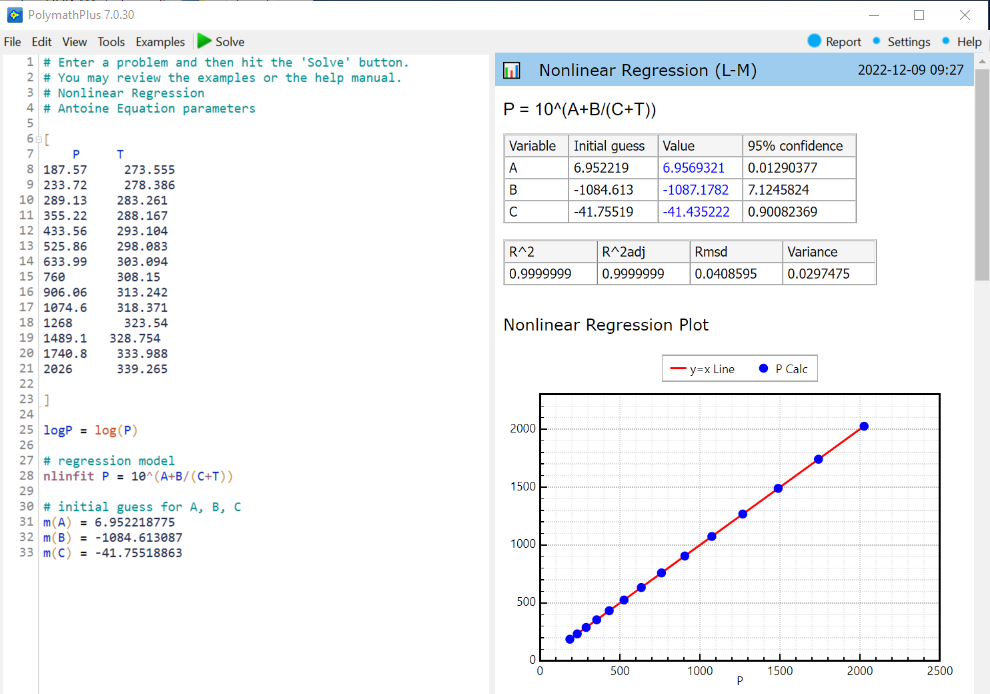

## Let's try fitting the logP form and use non-linear regression

In [27]:
logPvap

array([2.27316338, 2.36869588, 2.46109316, 2.55049741, 2.63704921,
       2.72087014, 2.80208241, 2.88081359, 2.95715696, 3.03124684,
       3.10311925, 3.17292386, 3.24074888, 3.30663944])

In [28]:
# this is the function we want to fit to our data
def funcNL(T, A, B, C):
    #'nonlinear function in ko and E to fit to data'
    logPvap=(A+B/(T+C))
    return logPvap
#From a multiple linear fit the parameters are:
initial_guess = [A,B,C]

#pars, pcov = curve_fit(funcNL, T, Pvap, p0=initial_guess)
pars, pcov = curve_fit(funcNL, T, logPvap, p0=initial_guess)
print('pars=', pars)
print('pcov=',pcov)


pars= [    6.95228839 -1084.64967281   -41.75078333]
pcov= [[ 1.21945497e-05 -6.39118612e-03  7.67466501e-04]
 [-6.39118612e-03  3.35364771e+00 -4.03185581e-01]
 [ 7.67466501e-04 -4.03185581e-01  4.85291237e-02]]


## The POLYMATH Plus program gave for regressing log Pvap
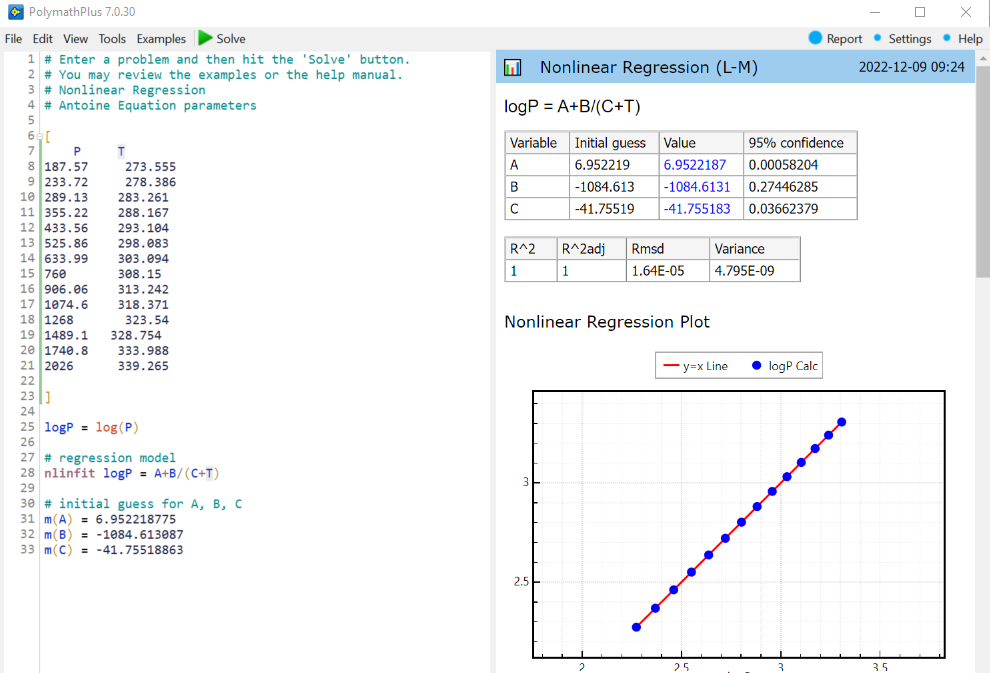

In [ ]:
# this is the function we want to fit to our data
def funcNL(T, A, B, C):
    #'nonlinear function in ko and E to fit to data'
    logPvap=(A+B/(T+C))
    return logPvap
#From a multiple linear fit the parameters are:
initial_guess = [2.5792175,-143.59313,834.35135]
print(initial_guess)
#pars, pcov = curve_fit(funcNL, T, Pvap, p0=initial_guess)
pars, pcov = curve_fit(funcNL, T, logPvap, p0=initial_guess)
print('pars=', pars)
print('pcov=',pcov)


In [ ]:
alpha = 0.05 # 95% confidence interval = 100*(1-alpha)

n = len(Pvap)    # number of data points
p = len(pars) # number of parameters

dof = max(0, n - p) # number of degrees of freedom

# student-t value for the dof and confidence level
tval = t.ppf(1.0-alpha/2., dof) 
print('    Parameter  +/- 95% confidence  [lower 95%   upper 95%]')
for i, p,var in zip(range(n), pars, np.diag(pcov)):
    sigma = var**0.5
    
    print ('p{:d}: {:7.5f} +/- {:7.5f}       [{:7.5f}  {:7.5f}]'
           .format(i, p,sigma*tval,p - sigma*tval,p + sigma*tval))
